# Autotalker Batch Integration Mouse Organogenesis Imputed

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 30.01.2023
- **Date of Last Modification:** 31.01.2023

## 1. Setup

### 1.1 Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../autotalker")

In [4]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import bbknn
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context
from sklearn.decomposition import KernelPCA

from autotalker.benchmarking import compute_rclisi, compute_cad
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 58592), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 58596), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 58608), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [5]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1"
batch2 = "embryo2"
batch3 = "embryo3"
n_neighbors = 4
reference_removed_cell_type = "Presomitic mesoderm"

## Model
# AnnData Keys
counts_key = "log_normalized_counts" # raw counts not available
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 3
log_variational = False # log normalized counts as input

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
query_cond_embed_lr = 0.01
lambda_edge_recon = 0.001
lambda_gene_expr_recon = 0.00033

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [6]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [7]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [8]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [9]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data

In [10]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_imputed.h5ad")

In [11]:
# Use log normalized counts as raw counts are not available
adata.layers["log_normalized_counts"] = adata.X

# Keep only highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    batch_key="batch",
    subset=True)

In [12]:
# Split adata into different batches
adata_batch1 = adata[adata.obs["batch"] == "embryo1"]
adata_batch2 = adata[adata.obs["batch"] == "embryo2"]
adata_batch3 = adata[adata.obs["batch"] == "embryo3"]

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3]

### 2.2 Remove Selected Cell Type from Reference for Recovery by Query

In [13]:
# Artificially remove cell type from reference for recovery by query
for i in range(len(adata_batch_list[:-1])):
    adata_batch_list[i] = adata_batch_list[i][adata_batch_list[i].obs["celltype_mapped_refined"] != reference_removed_cell_type]

In [14]:
for i in range(len(adata_batch_list)):
    adata_batch_list[i].obs["query_specific_cell_type"] = "Cell type present in reference"
    adata_batch_list[i].obs.loc[adata_batch_list[i].obs[cell_type_key] == reference_removed_cell_type, "query_specific_cell_type"] = reference_removed_cell_type

Using dataset seqfish_mouse_organogenesis_imputed.
Number of nodes (cells): 52568
Number of node features (genes): 4000


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


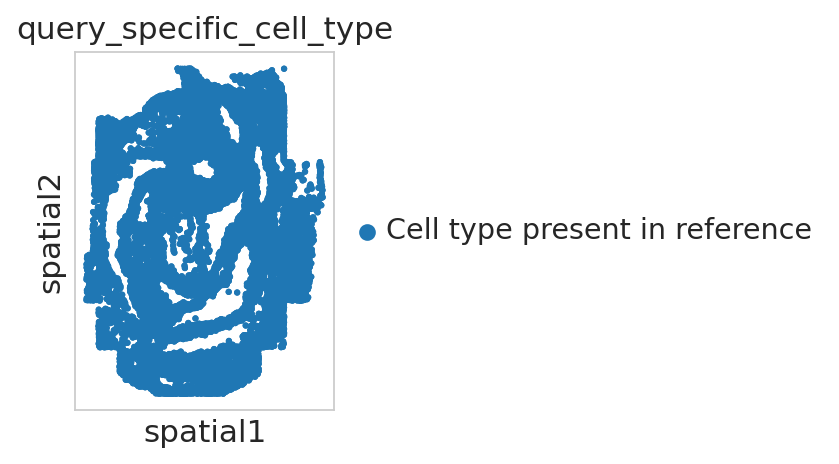

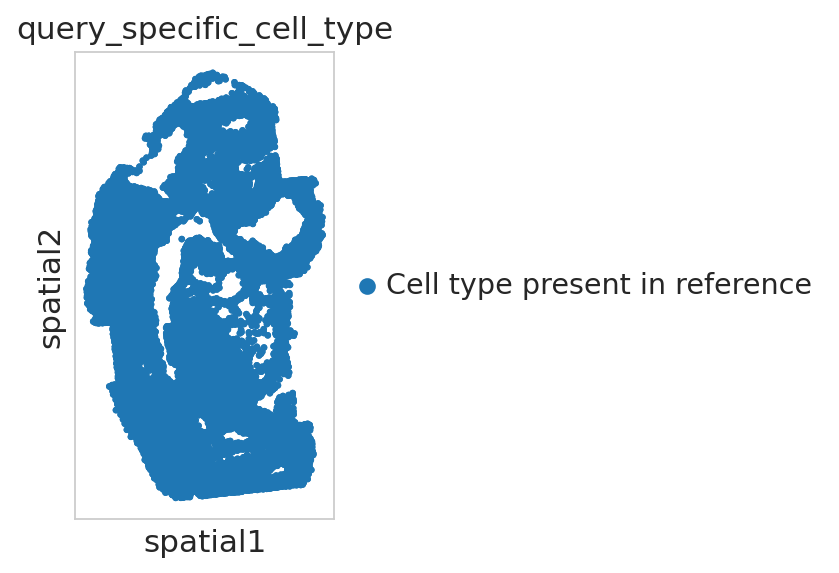

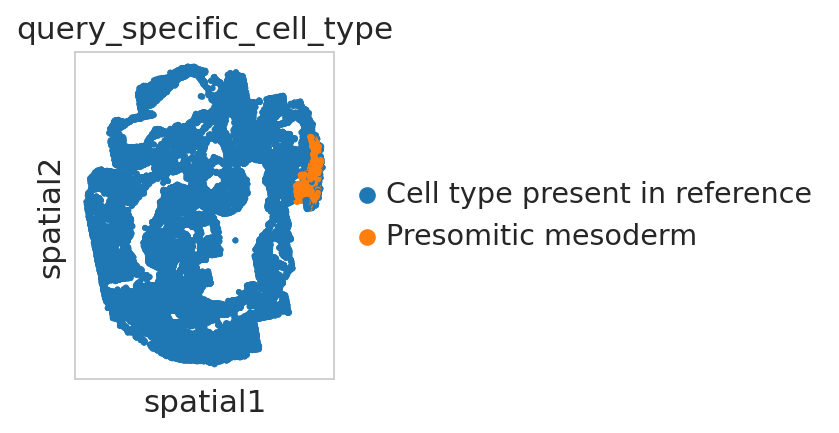

In [15]:
print(f"Using dataset {dataset}_imputed.")
print(f"Number of nodes (cells): {adata.X.shape[0]}")
print(f"Number of node features (genes): {adata.X.shape[1]}")

for adata_batch in adata_batch_list:
    # Visualize cell-level annotated data in spatial space
    sq.pl.spatial_scatter(adata_batch, color="query_specific_cell_type", shape=None, figsize=(5, 5))

### 2.3 Compute Spatial Neighbor Graphs

In [16]:
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp["spatial_connectivities"] = adata_batch_list[i].obsp["spatial_connectivities"].maximum(
        adata_batch_list[i].obsp["spatial_connectivities"].T)

### 2.4 Combine Data for BBKNN Batch Integration

In [17]:
adata_bbknn = ad.concat(adata_batch_list, join="inner")

### 2.5 Combine Data for One-Shot Batch Integration

In [ ]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0])))
connectivities_extension_batch3 = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3,
                                   adata_batch_list[2].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3))

adata_one_shot.obsp["spatial_connectivities"] = connectivities

### 2.6 Combine Data for Query-to-Reference Mapping

In [ ]:
adata_reference = ad.concat(adata_batch_list[:-1], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0])))
connectivities_extension_batch2 = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                 (adata_batch_list[0].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2,
                                   adata_batch_list[1].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2))

adata_reference.obsp["spatial_connectivities"] = connectivities

adata_query = adata_batch_list[2]

In [ ]:
adata_reference_query = adata_one_shot.copy()

reference_batches = adata_reference.obs["batch"].unique().tolist()
query_batches = adata_query.obs["batch"].unique().tolist()
adata_reference_query.obs["mapping_entity"] = None
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(reference_batches), "mapping_entity"] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(query_batches), "mapping_entity"] = "query"

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [ ]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [ ]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

In [ ]:
for adata in adata_batch_list + [adata_one_shot, adata_reference, adata_reference_query]:
    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key="autotalker_gp_targets",
        gp_sources_mask_key="autotalker_gp_sources",
        gp_names_key="autotalker_gp_names",
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm['autotalker_gp_sources'].sum()}.")

### 3.2 BBKNN Batch Integration Baseline

#### 3.2.1 Initialize, Train & Save Batch-Specific Models

In [ ]:
latent_bbknn_list = []
for i in range(len(adata_batch_list)):
    # Initialize model
    model = Autotalker(adata_batch_list[i],
                       counts_key=counts_key,
                       adj_key=adj_key,
                       condition_key=condition_key,
                       cond_embed_injection=["encoder",
                                             "gene_expr_decoder",
                                             "graph_decoder"],
                       n_cond_embed=n_cond_embed,
                       gp_names_key=gp_names_key,
                       active_gp_names_key=active_gp_names_key,
                       gp_targets_mask_key=gp_targets_mask_key,
                       gp_sources_mask_key=gp_sources_mask_key,
                       latent_key=latent_key,
                       active_gp_thresh_ratio=active_gp_thresh_ratio,
                       gene_expr_recon_dist=gene_expr_recon_dist,
                       n_hidden_encoder=n_hidden_encoder,
                       n_addon_gps=0,
                       log_variational=log_variational)
    print("")
    
    # Train model
    model.train(n_epochs,
                n_epochs_all_gps=n_epochs_all_gps,
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
                verbose=True)
    print("")
    
    # Save trained model
    model.save(dir_path=model_artifacts_folder_path + f"/bbknn_batch{i+1}",
               overwrite=True,
               save_adata=True,
               adata_file_name=f"{dataset}.h5ad")
    
    latent_bbknn_current_batch = model.get_latent_representation(
        adata=adata_batch_list[i],
        counts_key=counts_key,
        condition_key=condition_key,
        only_active_gps=False)
    
    latent_bbknn_list.append(latent_bbknn_current_batch)
    
adata_bbknn.obsm[latent_key] = np.vstack(latent_bbknn_list)

# Store adata to disk
adata_bbknn.write(f"{srt_data_gold_folder_path}/{dataset}_bbknn.h5ad")

In [97]:
# Read adata from disk
adata_bbknn = sc.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_bbknn.h5ad")

#### 3.2.2 Correct Batch Effects with BBKNN

In [98]:
# Compute batch-corrected latent nearest neighbor graph
bbknn.bbknn(adata=adata_bbknn,
            batch_key=condition_key,
            use_rep=latent_key)

adata_bbknn.obsp[f"{latent_knng_key}_connectivities"] = (
    adata_bbknn.obsp["connectivities"])

adata_bbknn.obsp[f"{latent_knng_key}_distances"] = (
    adata_bbknn.obsp["distances"])

#### 3.2.3 Analyze Latent Space

In [99]:
# Use batch-corrected latent space for UMAP generation
sc.tl.umap(adata_bbknn)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


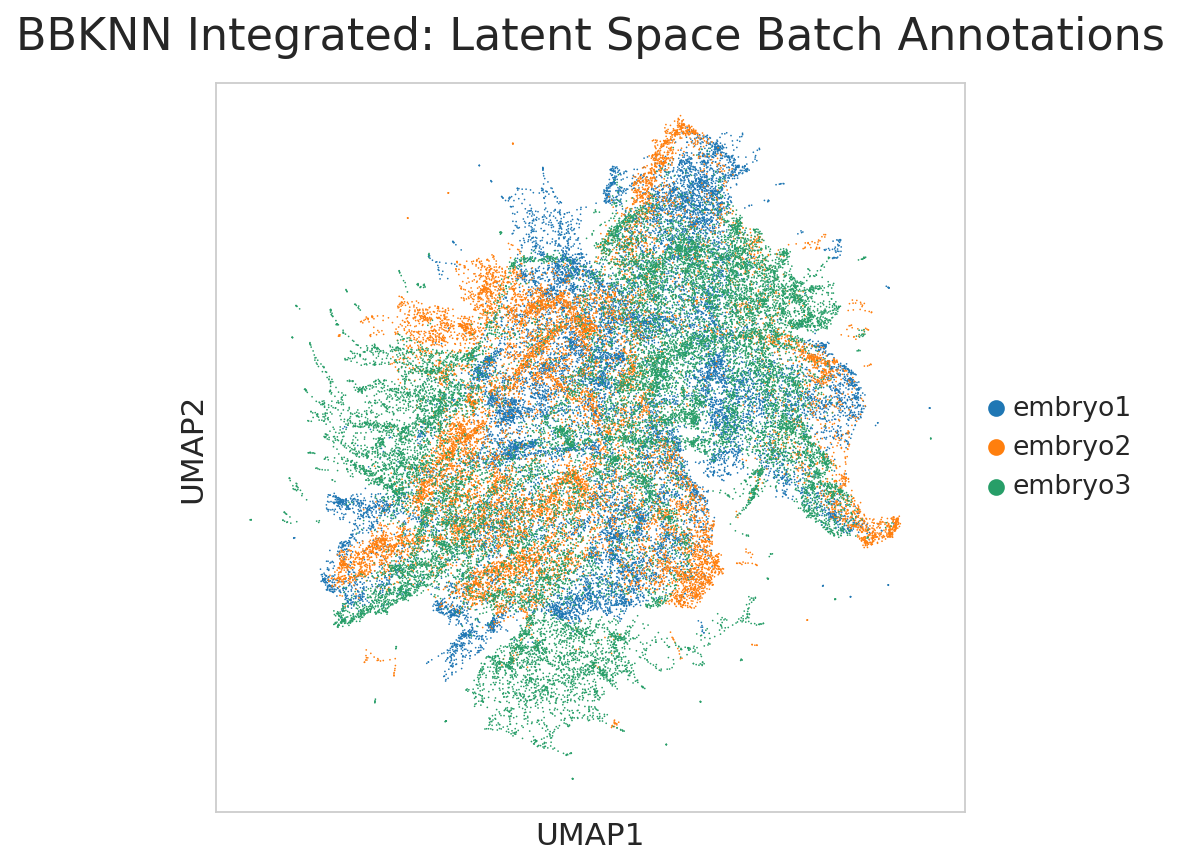

In [100]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_bbknn,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("BBKNN Integrated: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_bbknn.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


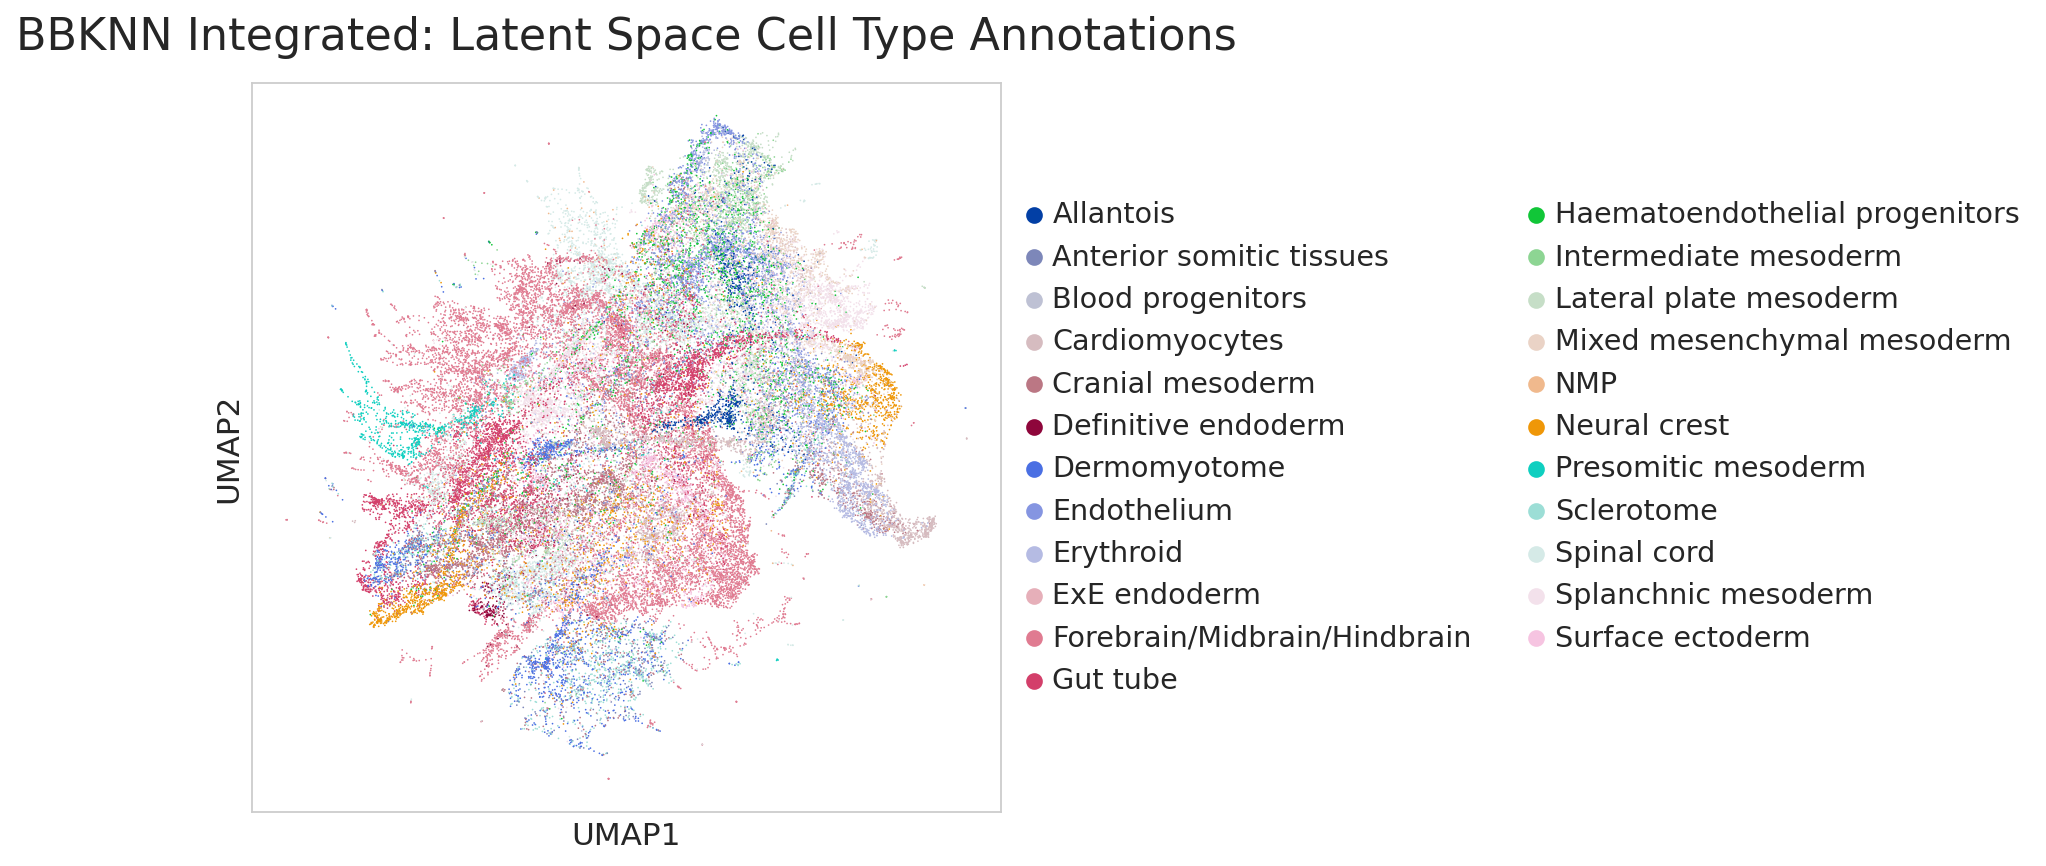

In [101]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_bbknn,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("BBKNN Integrated: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_bbknn.png",
            bbox_inches="tight")

#### 3.3.4 Analyze Metrics

In [ ]:
metrics_dict_bbknn = {}

metrics_dict_bbknn["cad"] = compute_cad(
    adata=adata_bbknn,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)

metrics_dict_bbknn["rclisi"] = compute_rclisi(
    adata=adata_bbknn,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
metrics_dict_bbknn["batch_asw"] = scib.me.silhouette_batch(
    adata=adata_bbknn,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed="X_umap")

metrics_dict_bbknn["kbet"] = scib.me.kBET(
    adata_bbknn,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="knn")

print(metrics_dict_bbknn)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/metrics_bbknn.pickle", "wb") as f:
    pickle.dump(metrics_dict_bbknn, f)

Computing spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
Chunk 5860 does not have enough neighbors. Skipping...
Chunk 5925 does not have enough neighbors. Skipping...
Chunk 6229 does not have enough neighbors. Skipping...
Chunk 6244 does not have enough neighbors. Skipping...
Chunk 6264 does not have enough neighbors. Skipping...
Chunk 6273 does not have enough neighbors. Skipping...
Chunk 6291 does not have enough neighbors. Skipping...
Chunk 7988 does not have enough neighbors. Skipping...
Chunk 7991 does not have enough neighbors. Skipping...
Chunk 8000 does not have enough neighbors. Skipping...
Chunk 14532 does not have enough neighbors. Skipping...
Chunk 14547 does not have enough neighbors. Skipping...
Chunk 14585 does not have enough neighbors. Skipping...
Chunk 14823 does not have enough neighbors. Skipping...
Chunk 14830 does not have en

### 3.4 One-Shot Batch Integration

#### 3.4.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.4.2 Load Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

#### 3.4.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: One-Shot Integration With Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_cond_embed.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: One-Shot Integration With Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_cond_embed.png",
            bbox_inches="tight")

#### 3.4.4 Analyze Metrics

In [ ]:
batch_correction_metrics_one_shot_cond_embed = {}

batch_correction_metrics_one_shot_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_cond_embed, f)

#### 3.4.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("One-Shot Integration Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/one_shot_cond_embed.png",
            bbox_inches="tight")

### 3.5 Query-to-Reference Mapping

#### 3.5.1 Building the Reference

##### 3.5.1.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention",
                   log_variational=log_variational)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.5.1.2 Load Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.5.1.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Autotalker Reference: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Autotalker Reference: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference.png",
            bbox_inches="tight")

##### 3.5.1.4 Analyze Metrics

In [ ]:
metrics_dict_reference = {}

metrics_dict_reference["cad"] = compute_cad(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)

metrics_dict_reference["arclisi"] = compute_arclisi(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)
    
metrics_dict_reference["batch_asw"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(metrics_dict_reference)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/reference_metrics.pickle", "wb") as f:
    pickle.dump(metrics_dict_reference, f)

##### 3.5.1.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/reference_cond_embed.png",
            bbox_inches="tight")

#### 3.5.2 Mapping the Query

##### 3.5.2.1 Initialize, Train & Save Model

In [ ]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=query_cond_embed_lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.5.2.2 Load Model

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_query",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.5.2.3 Analyze Latent Space

In [ ]:
adata_reference_query.obsm[latent_key] = model.get_latent_representation(
    adata=adata_reference_query,
    counts_key=counts_key,
    condition_key="batch")

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Autotalker Reference + Query: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with mapping entity annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["mapping_entity"],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Mapping Entity Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with recovered cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Autotalker Reference + Query: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with recovered cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["recovered_cell_type"],
                 return_fig=True)
plt.title("Autotalker Reference + Query: Latent Space Cell Type Annotations", size=20, pad=15)

In [ ]:
adata_reference_query.obs["recovered_cell_type"] = "Cell types present in reference"
adata_reference_query.obs.loc[adata_reference_query.obs[cell_type_key] == reference_removed_cell_type, "recovered_cell_type"] = reference_removed_cell_type

In [ ]:
# Plot UMAP with reference removed cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["recovered_cell_type"],
                 return_fig=True)
plt.title("Reference + Query: Latent Space Recovered Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_recovered_cell_types_reference_query.png",
            bbox_inches="tight")

##### 3.5.2.4 Analyze Metrics

In [ ]:
metrics_dict_reference_query = {}

metrics_dict_reference_query["cad"] = compute_cad(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)

metrics_dict_reference_query["arclisi"] = compute_arclisi(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)
    
metrics_dict_reference_query["batch_asw"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(metrics_dict_reference_query)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/reference_metrics.pickle", "wb") as f:
    pickle.dump(metrics_dict_reference_query, f)

##### 3.5.2.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = adata_reference_query.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference + Query Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/reference_query_cond_embed.png",
            bbox_inches="tight")

In [ ]:
for batch, adata_batch in zip([f"batch{i+1}" for i in range(6)], adata_batch_list):
    # Initialize model
    model = Autotalker(adata_batch_list[0],
                       counts_key=counts_key,
                       adj_key=adj_key,
                       condition_key=None,
                       gp_names_key=gp_names_key,
                       active_gp_names_key=active_gp_names_key,
                       gp_targets_mask_key=gp_targets_mask_key,
                       gp_sources_mask_key=gp_sources_mask_key,
                       latent_key=latent_key,
                       active_gp_thresh_ratio=active_gp_thresh_ratio,
                       gene_expr_recon_dist=gene_expr_recon_dist,
                       n_hidden_encoder=n_hidden_encoder,
                       n_addon_gps=0,
                       node_label_method="one-hop-attention")

    # Train model
    model.train(n_epochs,
                n_epochs_all_gps=n_epochs_all_gps,
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

    # Compute metrics
    metrics_dict = {}

    metrics_dict["cad"] = compute_cad(
        adata=model.adata,
        cell_type_key=cell_type_key,
        spatial_knng_key=spatial_knng_key,
        latent_knng_key=latent_knng_key,
        spatial_key=spatial_key,
        latent_key=latent_key,
        n_neighbors=n_neighbors)

    metrics_dict["arclisi"] = compute_arclisi(
        adata=model.adata,
        cell_type_key=cell_type_key,
        spatial_key=spatial_key,
        latent_key=latent_key,
        n_neighbors=n_neighbors)

    """
    metrics_dict["batch_asw"] = scib.me.silhouette_batch(
        adata=model.adata,
        batch_key=condition_key,
        label_key=cell_type_key,
        embed=latent_key)
    """

    print("/n", metrics_dict, "/n")

    # Store to disk
    with open(f"{model_artifacts_folder_path}"
              "/metrics_unintegrated_{batch}.pickle", "wb") as f:
        pickle.dump(metrics_dict, f)